<a href="https://colab.research.google.com/github/MatteoZancanaro-5758278/M_Zancanaro-Programming-BigDataAnalytics/blob/main/Assignment_5/5_02_Random_Forest_and_GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.02 Random Forest and Gradient Boosting Decision Trees
In this notebook we will extend the previous notebook by also looking at Random Forest and two GBDT implementations (the native scikit-learn implementation and also _eXtreme Gradient Boosting Decision Trees_ - _XGBDT_). The latter is basically a slighly more sophisticated implementation.
I used a credit risk dataset in Kaggle since the data was not provided for this coding session

In [31]:
from google.colab import files
uploaded = files.upload()

Saving credit_risk_dataset.csv to credit_risk_dataset (1).csv


In [32]:
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.read_csv("credit_risk_dataset.csv")

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [34]:
df.isna().sum()
df.shape

(32581, 12)

In [35]:
df = df.dropna()

categorical_cols = df.select_dtypes(include=["object"]).columns
print("Categorical columns:", list(categorical_cols))


Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [36]:
# 4. One-hot encode categorical columns (drop_first avoids dummy trap)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 5. Check the result
print("Shape after encoding:", df_encoded.shape)

df_encoded = pd.DataFrame(df_encoded)

display(df_encoded.head())

Shape after encoding: (28638, 23)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,True,False,False,False,True,False,False,False,False,True


In [39]:
y_value = df_encoded["loan_status"]
y_values = np.ravel(y_value)

x_values = df_encoded.drop("loan_status", axis=1)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=4567, stratify=y_value)

In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22910, 22)
(5728, 22)
(22910,)
(5728,)


## Modeling and Evaluation
We will set up algorithms for logistic regression (the previous winner) and then our new algorithms.

Just to look at the impact of hyperparameter optimisation, we will set them up initially with default hyperparameters and compare their performance (on the training data):

In [45]:
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from xgboost import XGBClassifier as XGB
from sklearn.metrics import precision_recall_fscore_support

LogR_algo = LogR()
LogR_model = LogR_algo.fit(x_train, y_train)

RF_algo = RF()
RF_model = RF_algo.fit(x_train, y_train)

GBDT_algo = GBDT()
GBDT_model = GBDT_algo.fit(x_train, y_train)

XGB_algo = XGB()
XGB_model = XGB_algo.fit(x_train, y_train)

models = [LogR_model, RF_model, GBDT_model, XGB_model]
names = ["Logistic Regression", "Random Forest", "GBDT", "XGB"]

for i in range(4):
  print(f"Model: {names[i]}")

  predict = models[i].predict(x_train)
  precision, recall, fscore, support = precision_recall_fscore_support(y_train, predict, average="macro")
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {fscore}")
  print("\n")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Macro Precision: 0.7541322339294039
Macro Recall: 0.6494705426496555
Macro F1-score: 0.674653386012273


Model: Random Forest
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0


Model: GBDT
Macro Precision: 0.9290003585180185
Macro Recall: 0.8439512144313722
Macro F1-score: 0.8775852505700612


Model: XGB
Macro Precision: 0.971876695738461
Macro Recall: 0.9103403719842005
Macro F1-score: 0.9369770426656663




Random Forest and XGBDT score perfectly - but is it overfitting? Let's hyperparameter tune them and see the scores again (on training data):

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

#we get a load of warnings running the code so will suppress them
import warnings
warnings.filterwarnings("ignore")

#hyperparameter seearch function for re-usability

def random_search(algo, hyperparameters, X_train, Y_train):

  clf = RandomizedSearchCV(algo, hyperparameters, cv =5, random_state = 2015,
                           scoring = "precision_macro", n_iter=20, refit=True , n_jobs=-1, verbose=1)

  clf.fit(x_train, y_train)

  return clf.best_params_

#LogR
LogR_tuned_parameters = {
    "solver" : ["liblinear"], #oly this one as it does bot L1 and L2
    #C is the equivalent of aplha in L1/L2 regression, how much regularisation
    "C": uniform(loc=0.1, scale=19.9), #draw from a uniform distributionbetween 0.1 and 20
    "penalty" : ["l1", "l2", "elasticnet", None] #elasticnet is a mix of l1 and l2
}

LogR_best_params = random_search(LogR_algo, LogR_tuned_parameters, x_train, y_train)

#Random Forest
RF_tuned_parameters = {
    "n_estimators": randint(50,500),
    "max_depth": randint(2,7),
    "max_features": ["sqrt", "log2", None]
}

RF_best_params = random_search(RF_algo, RF_tuned_parameters, x_train, y_train)


#GBDT
GBDT_tuned_parameters = {
    "n_estimators": randint(25,250),
    "learning_rate": uniform(loc=0.01,scale= 0.5),
    "criterion": ["friedman_mse", "squared_error"],
    "max_depth": randint(2,7)
}

GBDT_best_params = random_search(GBDT_algo, GBDT_tuned_parameters, x_train, y_train)


#XGBT
XGB_tuned_parameters = {
    "n_estimators": randint(25,250),
    "eta": uniform(loc=0.01,scale= 0.49), #eta is learning rate
    "objective": ["binary:logistic", "binary:hinge"],
    "max_depth": randint(2,7)
}

XGB_best_params = random_search(XGB_algo, XGB_tuned_parameters, x_train, y_train)


#Training the models

LogR_algo = LogR(**LogR_best_params)
LogR_model = LogR_algo.fit(x_train, y_train)

RF_algo = RF(**RF_best_params)
RF_model = RF_algo.fit(x_train, y_train)

GBDT_algo = GBDT(**GBDT_best_params)
GBDT_model = GBDT_algo.fit(x_train, y_train)

XGB_algo = XGB(**XGB_best_params)
XGB_model = XGB_algo.fit(x_train, y_train)

#score the models
models = [LogR_model, RF_model, GBDT_model, XGB_model]

for i in range (len(models)):
  print(f"Model: {names[i]}")
  predict = models[i].predict(x_train)
  precision, recall, fscore, support = precision_recall_fscore_support(y_train, predict, average="macro")
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {fscore}")
  print("\n")








Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Model: Logistic Regression
Macro Precision: 0.8284092778075176
Macro Recall: 0.7587155023599459
Macro F1-score: 0.7851233938102733


Model: Random Forest
Macro Precision: 0.9337093395387358
Macro Recall: 0.807721096199177
Macro F1-score: 0.8513987106177907


Model: GBDT
Macro Precision: 0.9633863998863835
Macro Recall: 0.881024042136327
Macro F1-score: 0.9146409720854187


Model: XGB
Macro Precision: 0.9586070393906289
Macro Recall: 0.8664924296056313
Macro F1-score: 0.9029627771438065




In [50]:
for i in range(4):
  print(f"Model: {names[i]}")
  predict = models[i].predict(x_test)

  precision, recall, fscore, support = precision_recall_fscore_support(y_test, predict, average="macro")
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {fscore}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.8138302339022994
Macro Recall: 0.7523549543340085
Macro F1-score: 0.7761144942020963


Model: Random Forest
Macro Precision: 0.9287402772881119
Macro Recall: 0.8064021283079941
Macro F1-score: 0.8490935210011255


Model: GBDT
Macro Precision: 0.9455713687735454
Macro Recall: 0.863211153287849
Macro F1-score: 0.8964425679994423


Model: XGB
Macro Precision: 0.9468211206896552
Macro Recall: 0.8574333372782361
Macro F1-score: 0.8927964018969292




Looking at the best models

GBDT Confusion Matrix


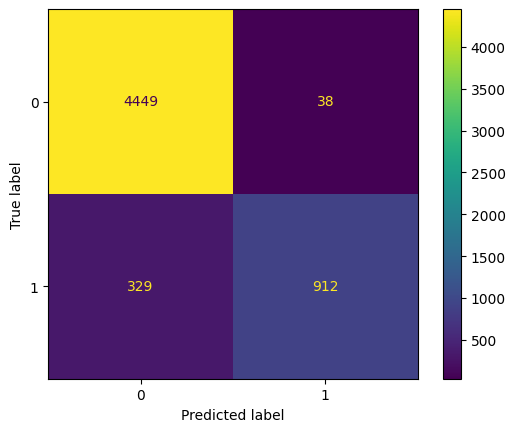

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

print("GBDT Confusion Matrix")
predict = GBDT_model.predict(x_test)
CM.from_predictions(y_test, predict)

XGB Confusion Matrix


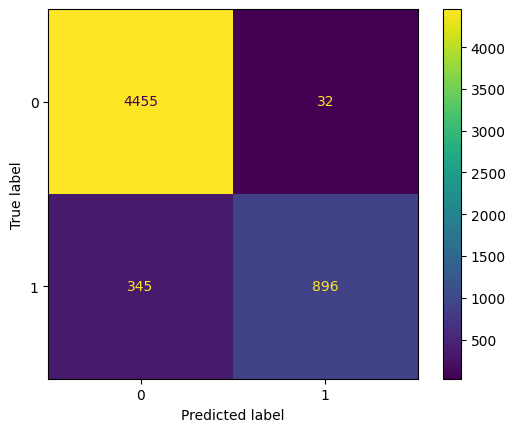

In [52]:
print("XGB Confusion Matrix")
predict = XGB_model.predict(x_test)
CM.from_predictions(y_test, predict)

The False positive are higher in GBDT so is probably the model to use...even though GBDT has more true positive the false negative and false positive are lower in XGB